In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans,DBSCAN,AffinityPropagation,AgglomerativeClustering

## 0. Data processing and visualization
1. Investigate the ratings.csv dataset, transform it to $(M,N)$ matrix so that each row represents a movie and each column represents a user. So M = number of unique movies, N = number of unique users. $r_{ij}$ is the rating j-th user gave to i-th movie.
2. Fill N/A values with 0.0
3. Investigate the resulting dataset, remove uninformative columns if any.
4. Perform exploratory analysis on the dataset.(correlation matrix, summary statistics barplots of features)

In [2]:
rate = pd.read_csv('ratings.csv',)
rate

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [3]:
%%time
rate = pd.read_csv('ratings.csv',)

new = np.zeros((rate['movieId'].nunique(),rate['userId'].nunique()))
index = sorted(list(set(rate['movieId'])))
columns = sorted(list(set(rate['userId'])))
new_data = pd.DataFrame(new,index=index,columns=columns)


for i,j,k in zip(rate['userId'],rate['movieId'],rate['rating']):
    new_data[i][j] = k



Wall time: 26.7 s


In [5]:
new_data1 = new_data.drop(new_data[new_data.duplicated(keep='last')==True].index,axis=0)
new_data1.shape

(6972, 610)

In [26]:
new_data1.describe()

In [32]:
%%time
std=-1*np.sort(-1*new_data1.describe().loc['std'])
mask = 0
new_data.describe().loc['std']
for i in new_data.columns:
     if new_data[i].std() == std[mask]:
        new_data[i].plot.bar()
        plt.show()
        mask+=1

## 1. Reducing Dimentionality of Data
All clustering algorithms benefit from dimensionality reduction. In this task perform PCA and project the dataset to lower dimension. Preserve at least 0.9 of initial variance

In [7]:
%%time
pca = PCA(n_components=0.9)
P1 = pca.fit_transform(new_data1)
P1.shape

Wall time: 2.71 s


(6972, 252)

## 2. Clustering
1. On the projected dataset fit KMeans, choose the best k from values $1,2,...,30$, report silhouette score of the best k
2. On the projected dataset decide minPts and eps, afterwards fit DBSCAN with chosen params, report the silhouette score
3. On the projected dataset fit 3 affinity propagation models, by setting preference to minimum of similarity matrix, mean of similarity matrix, median of similarity matrix.
Report the silhouette scores and choose the best one according to it.
4. Use scipy.cluster.hierarchy.linkage and scipy.cluster.hierarchy.dendrogram to plot dendrograms for [single, average, ward] linkages. Choose best k for each linkages from the dendrograms. Fit aglomerative clustering using the k-s that you chose. Report the three silhouette scores and choose the best model. Use the projected dataset for this task too.


In [43]:
%%time
# Kmeans
np.random.seed(40)
sil = 0
R = np.random.choice(list(range(0,len(P1))),int(len(P1)*0.3))
sil = 0
for i in range(2,31):
    Kmean = KMeans(n_clusters=i)
    model1 = Kmean.fit_predict(P1[R])
    silhouette_score1 = silhouette_score(P1[R],model1)
    if silhouette_score1>sil:
        sil = silhouette_score1
        k =i
    else:
        break
        
print('The best k from values  1,2,...,30  is %s with silhouette_score = %s' %(k,sil))

The best k from values  1,2,...,30  is 2 with silhouette_score = 0.566707874958398
Wall time: 1.76 s


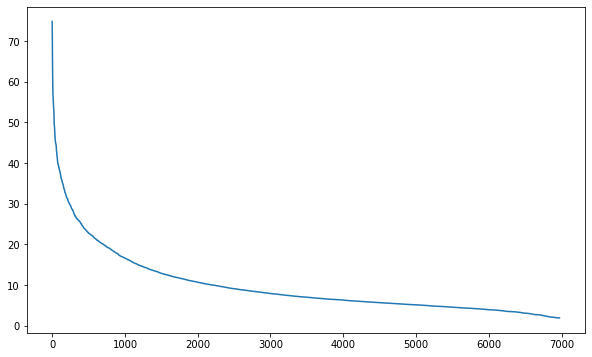

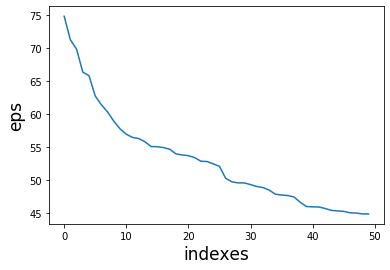

In [45]:
#2 DBSCAN
minPts = P1.shape[1] + 1
from sklearn.neighbors import KDTree
tree = KDTree(P1)
dist, ind = tree.query(P1,k=minPts)
fig = plt.figure(figsize=(10,6))
plt.plot(np.arange(P1.shape[0]),-1*np.sort(-1*dist.max(axis=1)))
plt.show()
plt.plot(np.arange(P1.shape[0])[:50],-1*np.sort(-1*dist.max(axis=1))[:50])
plt.xlabel('indexes',fontsize=17)
plt.ylabel('eps',fontsize=17)
plt.show()

In [ ]:
max1=0

for eps in range(12,18):
    DBSCAn = DBSCAN(eps = eps,min_samples=minPts)
    model2 = DBSCAn.fit_predict(P1)
    silhouette_score1 = silhouette_score(P1,model2)
    print('Silhouette_score is %s with minPts = %s and eps = %s' %(silhouette_score1,samp,eps))
    if abs(silhouette_score1)>max1:
        max1=abs(silhouette_score1)

        best_samp= samp
        best_eps = eps
            
print('The best Silhouette_score is %s with minPts = %s and eps = %s' %(max1,best_samp,best_eps))

In [ ]:
#3
%%time
#3 AFFINITY PROPAGATION

def sim_matrix(df,k='median'):
    df = pd.DataFrame(df)
    #similarity = np.zeros((df.shape[0],df.shape[0]),dtype=int)
    #similarity_matrix = pd.DataFrame(similarity)
    lst = []
    for j in range(df.shape[0]):
        for i in range(j,df.shape[0]):
            sim = ((df.iloc[j] - df.iloc[i])**2).sum()
            lst.append(-sim)
            #similarity_matrix[j][i]=-sim
            #similarity_matrix[i][j]=-sim
    if k == 'min':
        return min(lst)
    elif k == 'max':
        return max(lst)
    else:
        return np.median(np.array(lst))
    
            


minimum = sim_matrix(P1,k='min')
maximum = sim_matrix(P1,k='max')  
median = sim_matrix(P1)

In [ ]:
pref = [minimum,maximum,median]
max1 = 0
for i in pref:
    Aff = AffinityPropagation(preference=i-1.1)
    model3 = Aff.fit_predict(P1)
    silhouette_score1 = silhouette_score(P1,model3)
    if abs(silhouette_score1)>max1:
        max1 = abs(silhouette_score1)
        prefer = i-1.1
    if i == minimum:
        print('Silhouette_score is %s with preference = %s ' %(silhouette_score1,'min'))
    elif i==maximum:
        print('Silhouette_score is %s with preference = %s ' %(silhouette_score1,'max'))
    else:
        print('Silhouette_score is %s with preference = %s ' %(silhouette_score1,'median'))


print('\nThe best Silhouette_score is %s with preference = %s ' %(max1,prefer))

In [ ]:
#4
import sys
sys.setrecursionlimit(1000000)

R = np.random.choice(list(range(0,len(P1))),int(len(P1)*0.9))


linkage = ['single', 'average', 'ward']
max1 = 0
for link in linkage:
    for k in range(2,5):
        Agl = AgglomerativeClustering(n_clusters=k,linkage=link,)
        model4= Agl.fit_predict(P1)
        silhouette_score1 = silhouette_score(P1,model4)
        print('\nSilhouette_score is %s with k= %s and linkage = %s' %(silhouette_score1,k,link))
        if silhouette_score1>max1:
            max1=silhouette_score1
            bestK = k
            best_linkage = link
print('\nThe Best Silhouette_score is %s with k= %s and linkage = %s' %(max1,bestK,best_linkage))

    

## 3. Performing clustering and visualising the clusters
1. Use the projected dataset you got from task 1 project it to 2D using t-SNE(sklearn.manifold.TSNE). On the t-SNE projected dataset perform the same tasks as in task 2. 
2. Make four scatter plots for the four best models you got in task 3.1, by coloring points according to their cluster.
3. Using the model with the best silhouette score examine some movies that are in the same cluster, what do the clusters show?

In [34]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
projected = tsne.fit_transform(P1)


In [35]:
projected.shape

(6972, 2)

In [48]:
#1 KMEANS
sil = 0
for i in range(2,31):
    Kmean = KMeans(n_clusters=i)
    model1 = Kmean.fit_predict(projected[:1000])
    silhouette_score1 = silhouette_score(projected[:1000],model1)
    if silhouette_score1>sil:
        sil = silhouette_score1
        k =i
    else:
        break
        
print('The best k from values  1,2,...,30  is %s with silhouette_score = %s' %(k,sil))
Kmean = KMeans(n_clusters=k)
model1 = Kmean.fit_predict(projected[:1000])


The best k from values  1,2,...,30  is 4 with silhouette_score = 0.515655


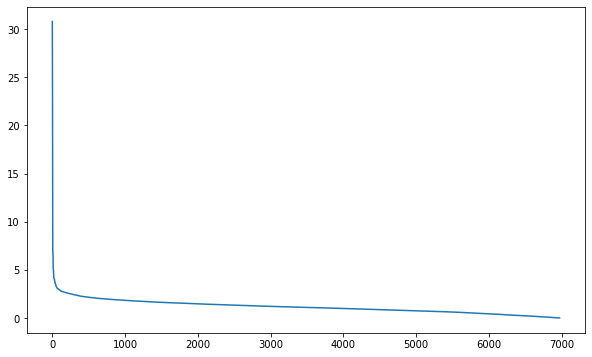

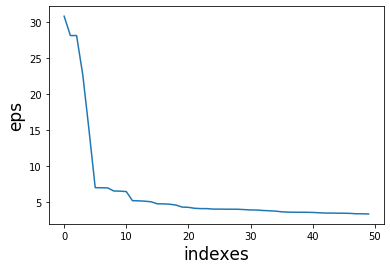

In [37]:
#2 DBSCAN
minPts = 2 * 2
from sklearn.neighbors import KDTree
tree = KDTree(projected)
dist, ind = tree.query(projected,k=minPts)
fig = plt.figure(figsize=(10,6))
plt.plot(np.arange(projected.shape[0]),-1*np.sort(-1*dist.max(axis=1)))
plt.show()
plt.plot(np.arange(projected.shape[0])[:50],-1*np.sort(-1*dist.max(axis=1))[:50])
plt.xlabel('indexes',fontsize=17)
plt.ylabel('eps',fontsize=17)
plt.show()

In [38]:
# The best eps will be 1-6
max1=0
for samp in [3,4]:
    for eps in range(1,6):
        DBSCAn = DBSCAN(eps = eps,min_samples=samp)
        model2 = DBSCAn.fit_predict(projected)
        silhouette_score1 = silhouette_score(projected,model2)
        print('Silhouette_score is %s with minPts = %s and eps = %s' %(silhouette_score1,samp,eps))
        if abs(silhouette_score1)>max1:
            max1=abs(silhouette_score1)
            
            best_samp= samp
            best_eps = eps
            
print('The best Silhouette_score is %s with minPts = %s and eps = %s' %(max1,best_samp,best_eps))
DBSCAn = DBSCAN(eps = best_eps,min_samples=best_samp)
model2 = DBSCAn.fit_predict(projected)

Silhouette_score is 0.17719354 with minPts = 3 and eps = 1
Silhouette_score is -0.18609437 with minPts = 3 and eps = 2
Silhouette_score is -0.4994947 with minPts = 3 and eps = 3
Silhouette_score is -0.34667084 with minPts = 3 and eps = 4
Silhouette_score is 0.026190858 with minPts = 3 and eps = 5
Silhouette_score is -0.05893224 with minPts = 4 and eps = 1
Silhouette_score is -0.15981081 with minPts = 4 and eps = 2
Silhouette_score is -0.46655536 with minPts = 4 and eps = 3
Silhouette_score is -0.32762384 with minPts = 4 and eps = 4
Silhouette_score is 0.034577202 with minPts = 4 and eps = 5
The best Silhouette_score is 0.4994947 with minPts = 3 and eps = 3


In [56]:
%%time
#3 AFFINITY PROPAGATION

def sim_matrix(df,k='median'):
    df = pd.DataFrame(df)
    #similarity = np.zeros((df.shape[0],df.shape[0]),dtype=int)
    #similarity_matrix = pd.DataFrame(similarity)
    lst = []
    for j in range(df.shape[0]):
        for i in range(j,df.shape[0]):
            sim = ((df.iloc[j] - df.iloc[i])**2).sum()
            lst.append(-sim)
            #similarity_matrix[j][i]=-sim
            #similarity_matrix[i][j]=-sim
    if k == 'min':
        return min(lst)
    elif k == 'max':
        return max(lst)
    else:
        return np.median(np.array(lst))
    
            


minimum = sim_matrix(projected[:150],k='min')
maximum = sim_matrix(projected[:150],k='max')  
median = sim_matrix(projected[:150])

Wall time: 25.6 s


In [82]:
minimum,maximum,median

(-16780.648, -0.0, -2874.92)

In [83]:
pref = [minimum,maximum,median]
max1 = 0
for i in pref:
    Aff = AffinityPropagation(preference=i)
    model3 = Aff.fit_predict(projected[:150])
    silhouette_score1 = silhouette_score(projected[:150],model3)
    if abs(silhouette_score1)>max1:
        max1 = abs(silhouette_score1)
        prefer = i
    if i == minimum:
        print('Silhouette_score is %s with preference = %s ' %(silhouette_score1,'min'))
    elif i==maximum:
        print('Silhouette_score is %s with preference = %s ' %(silhouette_score1,'max'))
    else:
        print('Silhouette_score is %s with preference = %s ' %(silhouette_score1,'median'))


print('\nThe best Silhouette_score is %s with preference = %s ' %(max1,prefer))
Aff = AffinityPropagation(preference=prefer)
model3 = Aff.fit_predict(projected[:150])


C:\Users\-Intel-\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

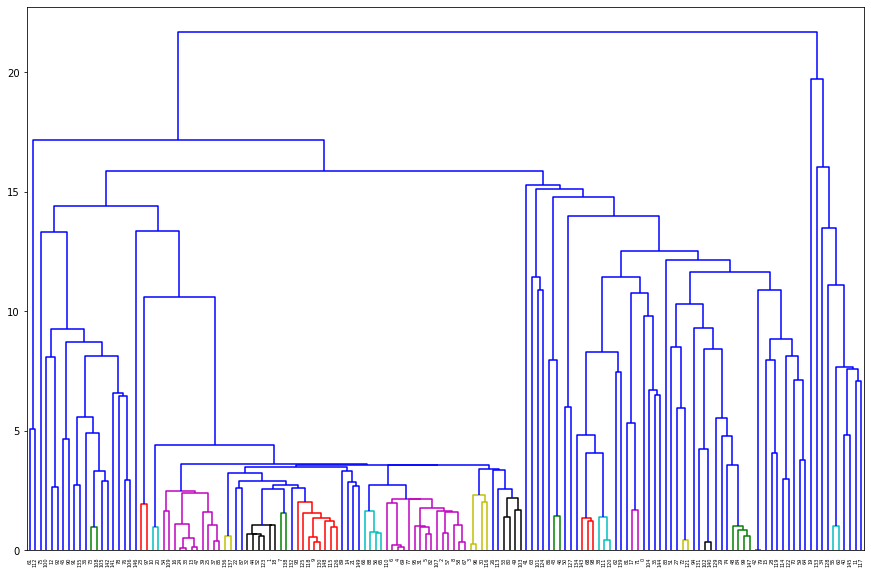

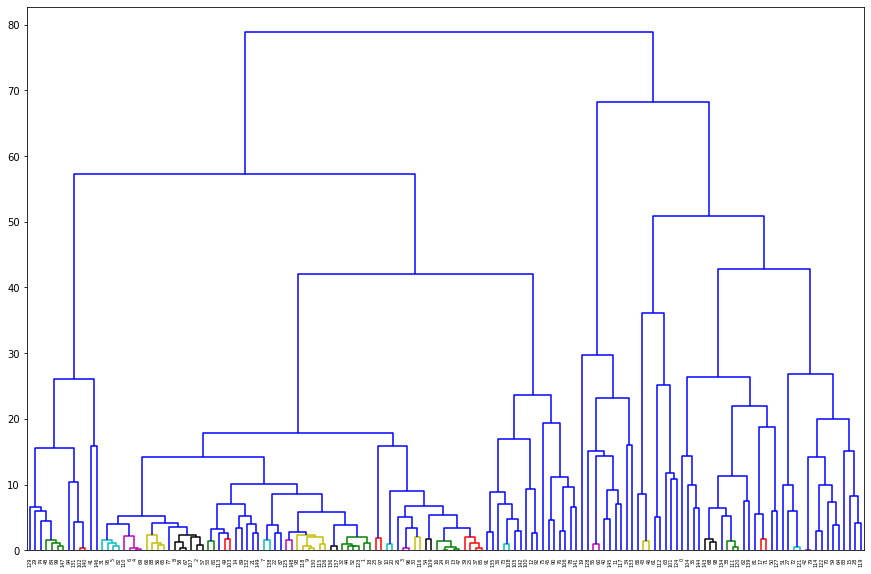

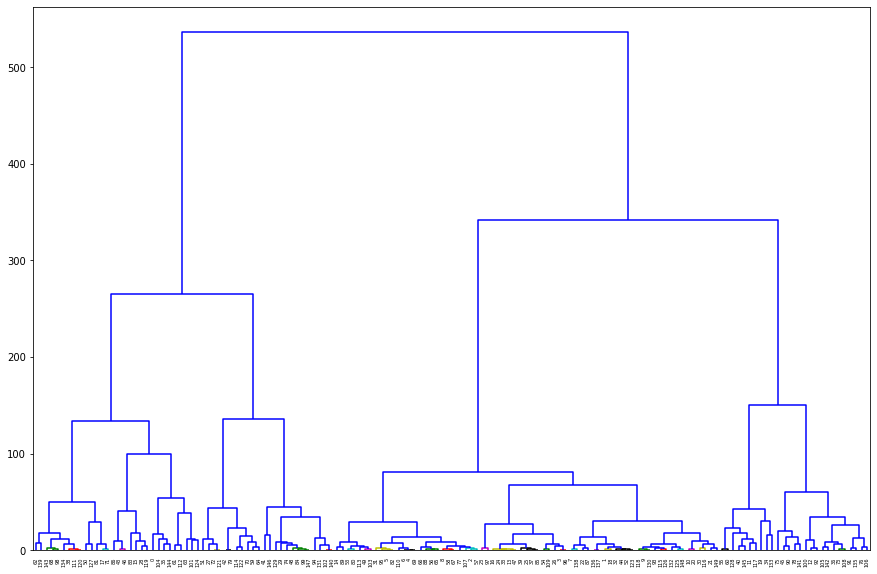

In [85]:
#Aglomerative clustering
import sys
sys.setrecursionlimit(1000000)
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
#R = np.random.choice(list(range(0,len(P1))),int(len(P1)*0.9))
dist = pdist(projected[:150])

linkage = ['single', 'average', 'ward']


for link in linkage:
    plt.figure(figsize=(15,10))
    a = hierarchy.linkage(dist,link)
    hierarchy.dendrogram(a,color_threshold=2.5)
    plt.show()

In [90]:
max1 = 0
for link in linkage:
    for k in range(2,5):
        Agl = AgglomerativeClustering(n_clusters=k,linkage=link,)
        model4= Agl.fit_predict(projected)
        silhouette_score1 = silhouette_score(projected,model4)
        print('\nSilhouette_score is %s with k= %s and linkage = %s' %(silhouette_score1,k,link))
        if silhouette_score1>max1:
            max1=silhouette_score1
            bestK = k
            best_linkage = link
print('\nThe Best Silhouette_score is %s with k= %s and linkage = %s' %(max1,bestK,best_linkage))
Agl = AgglomerativeClustering(n_clusters=bestK,linkage=best_linkage)
model4= Agl.fit_predict(projected)


Silhouette_score is 0.3602643 with k= 2 and linkage = single

Silhouette_score is 0.2079595 with k= 3 and linkage = single

Silhouette_score is 0.081225194 with k= 4 and linkage = single

Silhouette_score is 0.33914542 with k= 2 and linkage = average

Silhouette_score is 0.16355523 with k= 3 and linkage = average

Silhouette_score is 0.27930072 with k= 4 and linkage = average

Silhouette_score is 0.3309509 with k= 2 and linkage = ward

Silhouette_score is 0.3499583 with k= 3 and linkage = ward

Silhouette_score is 0.33050674 with k= 4 and linkage = ward

The Best Silhouette_score is 0.3602643 with k= 2 and linkage = single


## 3. Performing clustering and visualising the clusters
1. Use the projected dataset you got from task 1 project it to 2D using t-SNE(sklearn.manifold.TSNE). On the t-SNE projected dataset perform the same tasks as in task 2. 
2. Make four scatter plots for the four best models you got in task 3.1, by coloring points according to their cluster.
3. Using the model with the best silhouette score examine some movies that are in the same cluster, what do the clusters show?

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


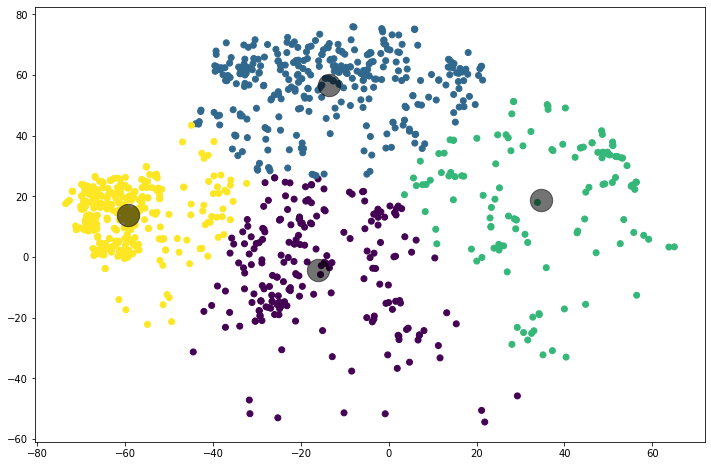

In [49]:
proj = projected[:300]
#3.2 Make four scatter plots for the four best models you got in task 3.1, by coloring points according to their cluster.
#first model is Kmean

print(Kmean)
fig = plt.figure(figsize=(12,8))
plt.scatter(projected[:1000,0],projected[:1000,1],c=model1)
plt.scatter(Kmean.cluster_centers_[:,0],Kmean.cluster_centers_[:,1],s=500,color='black',alpha='0.55')
plt.show()

DBSCAN(algorithm='auto', eps=3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=3, n_jobs=None, p=None)


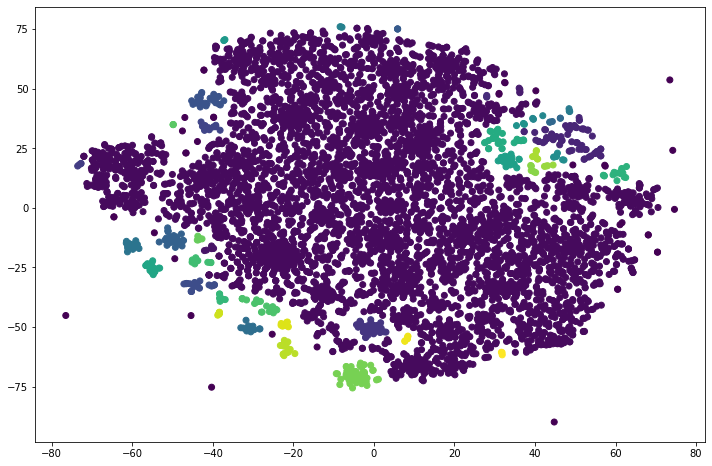

In [50]:
#Second model is DBSCAn
print(DBSCAn)
fig = plt.figure(figsize=(12,8))
plt.scatter(projected[:,0],projected[:,1],c=model2)


AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                    damping=0.5, max_iter=200, preference=-16781.7484375,
                    verbose=False)


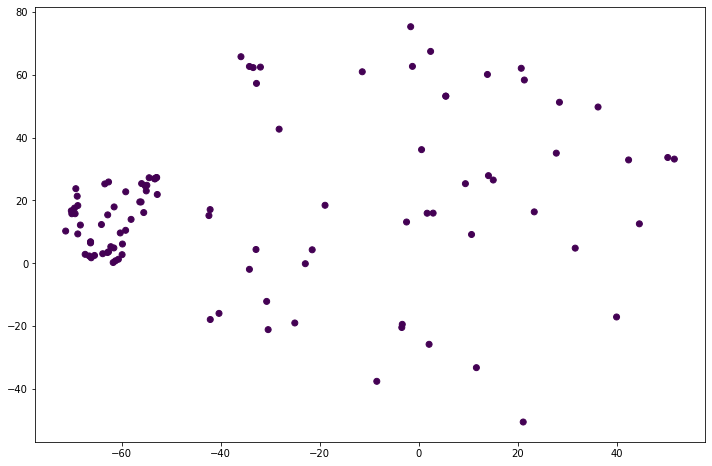

In [51]:
#Third model is AFFINITY PROPAGATION
print(Aff)
fig = plt.figure(figsize=(12,8))
plt.scatter(projected[:100,0],projected[:100,1],c=model3)
plt.scatter(Aff.cluster_centers_[:,0],Aff.cluster_centers_[:,1],s=500,color='black',alpha='0.55')
plt.show()


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='single', memory=None, n_clusters=2)


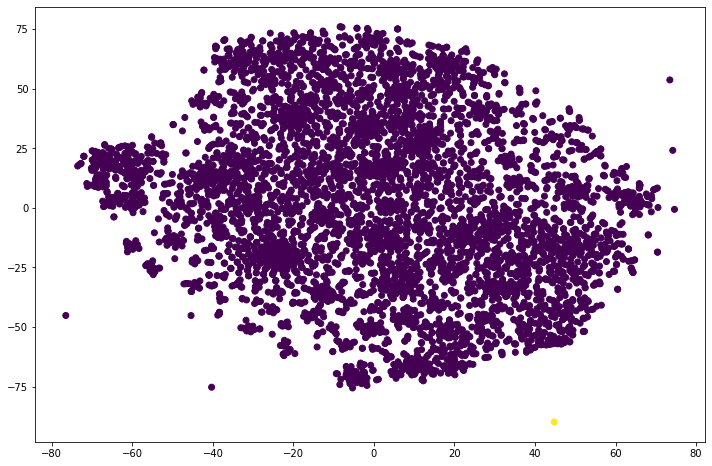

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [93]:
#4 Forth model is Aglomerative clustering
print(Agl)
fig = plt.figure(figsize=(12,8))
plt.scatter(projected[:,0],projected[:,1],c=model4)
plt.show()
